In [40]:
import matplotlib.pyplot as plt
import numpy as np

In [41]:
class Filament:
    def __init__(self, start, end, n_points, stiffness, dt):
        self.n_points = n_points
        self.stiffness = stiffness
        self.dt = dt
        self.positions = np.linspace(start, end, n_points)
        self.velocities = np.zeros_like(self.positions)

    def compute_spring_forces(self):
        forces = np.zeros_like(self.positions)
        for i in range(1, self.n_points - 1):
            left = self.positions[i - 1]
            center = self.positions[i]
            right = self.positions[i + 1]
            forces[i] = self.stiffness * ((left - center) + (right - center))
        return forces

    def interpolate_fluid_velocity(self, u):
        interpolated = np.zeros_like(self.positions)
        ny, nx, _ = u.shape
        for i, (x, y) in enumerate(self.positions):
            ix, iy = int(x), int(y)
            if 0 <= ix < nx and 0 <= iy < ny:
                interpolated[i] = u[iy, ix]
        return interpolated

    def update(self, u):
        fluid_velocity = self.interpolate_fluid_velocity(u)
        forces = self.compute_spring_forces()
        self.velocities = fluid_velocity + forces * self.dt
        self.positions += self.velocities * self.dt


In [42]:
def get_simulation_config():
    return {
        'nx': 100,              # lattice width
        'ny': 100,              # lattice height
        'tau': 0.6,             # relaxation time
        'timesteps': 500,       # number of time steps
        'output_interval': 100, # save/display interval
        'rho0': 1.0,            # initial density
        'u0': (0.1, 0.0),       # initial velocity (x, y)
    }

In [43]:
def create_obstacle_mask(nx, ny, center=None, radius=10):
    """Create a boolean mask for a circular obstacle."""
    if center is None:
        center = (nx // 2, ny // 2)
    y, x = np.ogrid[0:ny, 0:nx]
    mask = (x - center[0])**2 + (y - center[1])**2 < radius**2
    return mask

def initialize_lattice(config):
    nx, ny = config['nx'], config['ny']
    rho = np.ones((ny, nx)) * config['rho0']
    u = np.zeros((ny, nx, 2))
    u[:, :, 0] = config['u0'][0]
    u[:, :, 1] = config['u0'][1]

    # D2Q9 discrete velocities
    c = np.array([
        [ 0,  0], [ 1,  0], [ 0,  1], [-1,  0], [ 0, -1],
        [ 1,  1], [-1,  1], [-1, -1], [ 1, -1]
    ])

    # Weights for each direction
    w = np.array([4/9] + [1/9]*4 + [1/36]*4)

    f = np.zeros((9, ny, nx))
    for i in range(9):
        cu = 3 * (c[i, 0]*u[:,:,0] + c[i, 1]*u[:,:,1])
        f[i] = w[i] * rho * (1 + cu + 0.5*cu**2 - 1.5*(u[:,:,0]**2 + u[:,:,1]**2))

    obstacle_mask = create_obstacle_mask(nx, ny)
    return f, rho, u, c, w, obstacle_mask


In [44]:
def bounce_back(f, mask):
    # Bounce-back indices (D2Q9)
    bounce = [0, 3, 4, 1, 2, 7, 8, 5, 6]
    for i in range(9):
        f[i][:, :][mask] = f[bounce[i]][:, :][mask]
    return f

def collide_and_stream(f, rho, u, c, w, tau, obstacle_mask):
    ny, nx = rho.shape
    feq = np.zeros_like(f)

    # Collision step
    for i in range(9):
        cu = 3 * (c[i, 0] * u[:, :, 0] + c[i, 1] * u[:, :, 1])
        feq[i] = w[i] * rho * (1 + cu + 0.5 * cu**2 - 1.5 * (u[:, :, 0]**2 + u[:, :, 1]**2))
        f[i] += -(1.0 / tau) * (f[i] - feq[i])

    # Streaming step
    for i in range(9):
        f[i] = np.roll(f[i], shift=c[i][0], axis=1)
        f[i] = np.roll(f[i], shift=c[i][1], axis=0)

    # Bounce-back step
    bounce = [0, 3, 4, 1, 2, 7, 8, 5, 6]
    for i in range(9):
        f[i][obstacle_mask] = f[bounce[i]][obstacle_mask]

    # Macroscopic quantities
    rho = np.sum(f, axis=0)
    u[:, :, 0] = np.sum(f * c[:, 0].reshape(9, 1, 1), axis=0) / rho
    u[:, :, 1] = np.sum(f * c[:, 1].reshape(9, 1, 1), axis=0) / rho

    # Zero velocity in obstacle
    u[obstacle_mask, :] = 0

    return f, rho, u

def apply_lid_velocity(u, velocity=(0.1, 0.0)):
    u[-1, :, 0] = velocity[0]  # Top lid horizontal velocity
    u[-1, :, 1] = velocity[1]  # Top lid vertical velocity (0)
    return u

def add_force(f, u, rho, c, w, force=(1e-5, 0)):
    for i in range(9):
        cu = 3 * (c[i,0]*force[0] + c[i,1]*force[1])
        f[i] += w[i] * rho * cu
    return f

def display_velocity_field(u, mask, t, filaments=None):
    velocity_mag = np.sqrt(u[:, :, 0]**2 + u[:, :, 1]**2)
    velocity_mag[mask] = np.nan

    plt.imshow(velocity_mag, cmap='viridis')

    if filaments is not None:
        for filament in filaments:
            xs, ys = filament.positions[:, 0], filament.positions[:, 1]
            plt.plot(xs, ys, color='white', linewidth=1)
            plt.scatter(xs, ys, color='red', s=5)

    plt.title(f"Velocity magnitude at timestep {t}")
    plt.colorbar()
    plt.pause(0.01)
    plt.clf()

In [45]:
def run_simulation():
    config = get_simulation_config()
    f, rho, u, c, w, obstacle_mask = initialize_lattice(config)
    filaments = [
        Filament(start=np.array([20, 30]), end=np.array([80, 30]), n_points=30, stiffness=0.05, dt=1.0),
        Filament(start=np.array([50, 20]), end=np.array([50, 80]), n_points=30, stiffness=0.05, dt=1.0),
        Filament(start=np.array([30, 30]), end=np.array([70, 70]), n_points=30, stiffness=0.05, dt=1.0),
    ]

    for t in range(config['timesteps']):
        # u = apply_lid_velocity(u, velocity=config['u0'])
        f = add_force(f, u, rho, c, w, force=(1e-5, 0.0))  # Optional
        f, rho, u = collide_and_stream(f, rho, u, c, w, config['tau'], obstacle_mask)
        for filament in filaments:
            filament.update(u)

        if t % config['output_interval'] == 0:
            display_velocity_field(u, obstacle_mask, t, filaments)

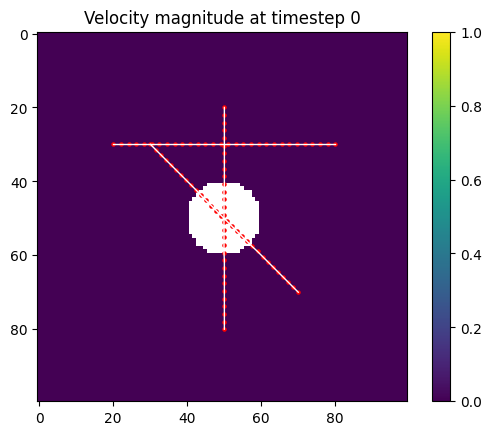

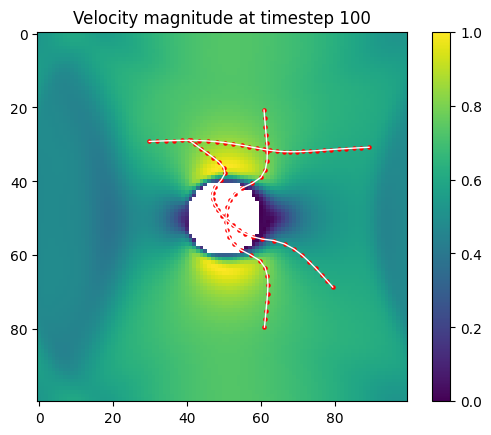

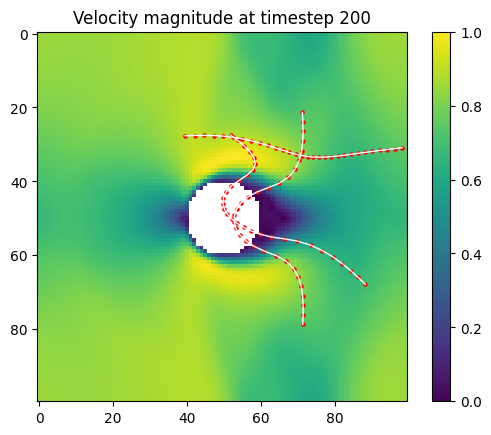

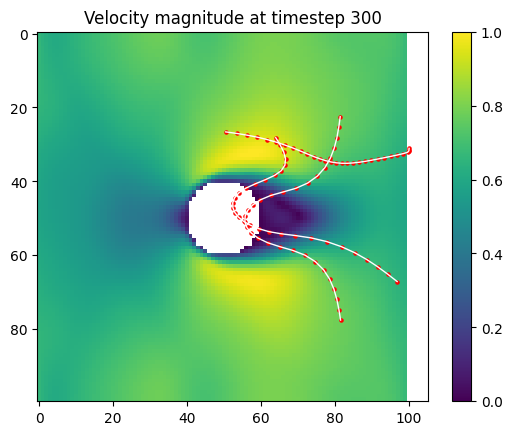

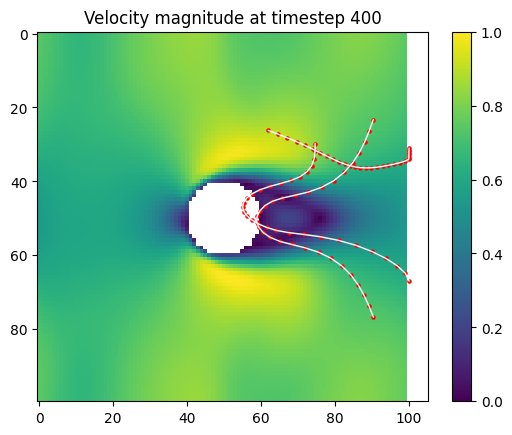

<Figure size 640x480 with 0 Axes>

In [46]:
run_simulation()